Chelsea Zackey
<br>CIS 5526: Final Project

## Classifying MNIST Data via Quantum Neural Network

This program aims to reproduce the original results of the tutorial given by TensorFlow Quantum: https://www.tensorflow.org/quantum/tutorials/mnist

In [1]:
#import packages
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import keras
import math

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from keras.datasets import mnist

In [2]:
# Methods for EDA & data preprocessing

# define method to filter data for binary classification problem using '3' and '6' examples only
def filter36(x, y):
# Method that accepts dataset x with labels y and returns the pair (x, y) comprising only the
# data points with labels y == 3 or y == 6. Also converts labels in y to boolean value: y == 3 evaluates
# to True, and y == 6 evaluates to False
    sieve = (y == 3) | (y == 6)
    x, y = x[sieve], y[sieve] # use boolean indexing to filter examples 
    y = (y == 3) # convert y to boolean label
    return x, y

#define method for removing "contradictory" examples belonging to both classes
def rm_contradictions(x, y):
# Given data x with binary labels y, return (x, y) with examples belonging to both classes comprising y
    m = collections.defaultdict(set) # create dictionary of sets
    
    for xx, yy in zip(x, y): # iterate through data set x with labels y
        m[tuple(xx.flatten())].add(yy) # add dict item with key given by data point xx and value given by yy
    
    # initialize return values (data points with unique labels; ie belonging to '3' XOR '6')
    new_x = []
    new_y = []
    
    # begin filtering unique examples xx with label yy satisfying: yy == 3 XOR yy == 6
    for xx, yy in zip(x, y):
        labels = m[tuple(xx.flatten())] # retrieve values associated with key
        if len(labels) == 1:
           # example xx belongs to single class; keep example & label pair
            new_x.append(xx)
            new_y.append(labels.pop())
        else:
            # example xx belongs to both classes; ignore contradictory example
            pass
    # find total remaining examples per each class: label True for '3' and False for '6' (not '3')
    num3s = sum(1 for yy in new_y if yy == True) # Fixed method from tutorial -CZ
    num6s = sum(1 for yy in new_y if yy == False) # Fixed method from tutorial -CZ
    num_contradictions = sum(1 for value in m.values() if len(value) == 2)
    
    print("\n==================== FILTERING OUT CONTRADICTORY EXAMPLES ====================")
    print("\nInitial number of 3-6 training examples: ", len(x))
    print("Remaining non-contradictory 3-6 training examples: ", len(new_x))
    print("Number of 3s: ", num3s)
    print("Number of 6s: ", num6s)
    print("Number of contradictory images removed from training set: ", num_contradictions)
    
    return np.array(new_x), np.array(new_y)

Total initial training examples: 60000
Total initial test examples: 10000

==================== FILTERING OUT NON-"3"-"6" EXAMPLES ====================

Total filtered 3-6 training examples: 12049
Total filtered 3-6 test examples: 1968


Image for first training example: 


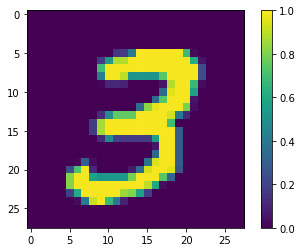



Rescaled image for first training example: 


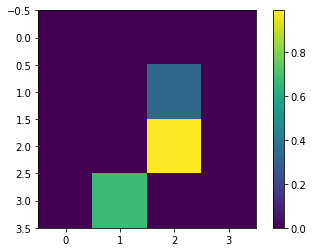


==================== FILTERING OUT CONTRADICTORY EXAMPLES ====================

Initial number of 3-6 training examples:  12049
Remaining non-contradictory 3-6 training examples:  10338
Number of 3s:  4912
Number of 6s:  5426
Number of contradictory images removed from training set:  49


In [3]:
# EDA & Data preprocessing for MNIST 3-6 Binary Classification

# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Total initial training examples:", len(x_train))
print("Total initial test examples:", len(x_test))

#rescale images to range [0.0, 1.0]
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0


# filter data
x_train, y_train = filter36(x_train, y_train)
x_test, y_test = filter36(x_test, y_test)
print("\n==================== FILTERING OUT NON-\"3\"-\"6\" EXAMPLES ====================")
print("\nTotal filtered 3-6 training examples:", len(x_train))
print("Total filtered 3-6 test examples:", len(x_test))

print("\n\nImage for first training example: ")
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()
plt.show()

# resize images to 4x4 scale for quantum computers
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()
print("\n\nRescaled image for first training example: ")
plt.imshow(x_train_small[0, :, :, 0])
plt.colorbar()
plt.show()


# remove contradictory examples (x, y): for all x, y, we have y == 3 XOR y == 6
x_train_rmcon, y_train_rmcon = rm_contradictions(x_train_small, y_train)

In [4]:
# Define methods for encoding data as quantum circuits

def to_circuit(image):
# Converts data given by image to quantum circuit (qubit) representation
    vals = np.ndarray.flatten(image) # values for each pixel in image as 1D array
    qbits = cirq.GridQubit.rect(4, 4) # initialize qubits residing in 4x4 dimensional grid (matrix)
    circ = cirq.Circuit() # return circuit comprising qubits and all operations performed on them
    for i, val in enumerate(vals):
        if val: # evaluates to true for nonzero values (assuming pixel values below threshold have been ignored)
            # rotate pixel exceeding threshold by pauli X gate
            circ.append(cirq.X(qbits[i])) # add rotated qbit representing pixel i to circ
    return circ

# Encode MNIST image data with qubits for quantum processors

thresh = 0.5 # threshold value used for binary (qubit) encoding of pixels 

# Convert pixels for x_train and x_test to binary values simulating qubits
x_train_bin = np.array(x_train_rmcon > thresh, dtype = np.float32)
x_test_bin = np.array(x_test_small > thresh, dtype=np.float32)

# "qubits" representing pixels with values above certain threshold will be rotated by 
# quantum X gate for (quantum) data preprocessing
x_train_circ = [to_circuit(x) for x in x_train_bin] # circuit representation of (binary) training set
x_test_circ = [to_circuit(x) for x in x_test_bin] # circuit representation of (binary) testing set

# TEST: display visuals for circuit representation of first training example
SVGCircuit(x_train_circ[0]) # displays grid coordinates of pixels rotated by X gate (pixels with values exceeding threshold)

# convert to tensors for TensorFlow Quantum package
x_train_tfq = tfq.convert_to_tensor(x_train_circ)
x_test_tfq = tfq.convert_to_tensor(x_test_circ)


==================== DISPLAYING DEMO qNN LAYER CIRCUIT  ====================


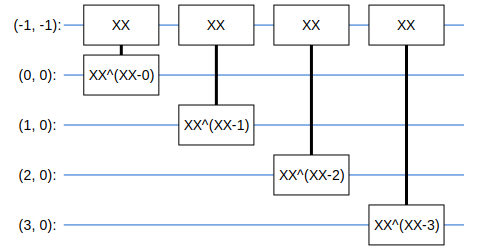

In [5]:
# Defining Quantum Neural Network (qNN) architecture

class CircLayerBuilder():
# Define class that adds a layer comprising n instances of the same quantum gate to a given circuit.
# In each such layer, each data qubit acts on the readout qubit
    
    def __init__(self, data_qbits, readout_qbit):
    # Constructor method
        self.data_qbits = data_qbits
        self.readout_qbit = readout_qbit
        
    def add_layer(self, circ, gate, prefix):
    # Given caller object (self) with n data qubits, adds a layer of n quantum gates specified 
    # by 'gate' acting on all i = 1, 2, ..., n qubits in self.data_qbits to circuit specified by 
    # 'circ', each gate being labeled with prefix specified by 'prefix'
    
    # i.e., this layer applies binary operation specified by gate acting on readout qbit and each individual data qbit
        for i, qbit in enumerate(self.data_qbits):
            label = sympy.Symbol(prefix + '-' + str(i))
            circ.append(gate(qbit, self.readout_qbit)**label)
            
# Demo methods from CircLayerBuilder class
demo_build = CircLayerBuilder(data_qbits = cirq.GridQubit.rect(4, 1), readout_qbit = cirq.GridQubit(-1, -1))
circuit = cirq.Circuit()
demo_build.add_layer(circuit, gate = cirq.XX, prefix='XX')
# Display demo circuit
print("\n==================== DISPLAYING DEMO qNN LAYER CIRCUIT  ====================")
SVGCircuit(circuit)


==================== DISPLAYING qNN MODEL CIRCUIT  ====================


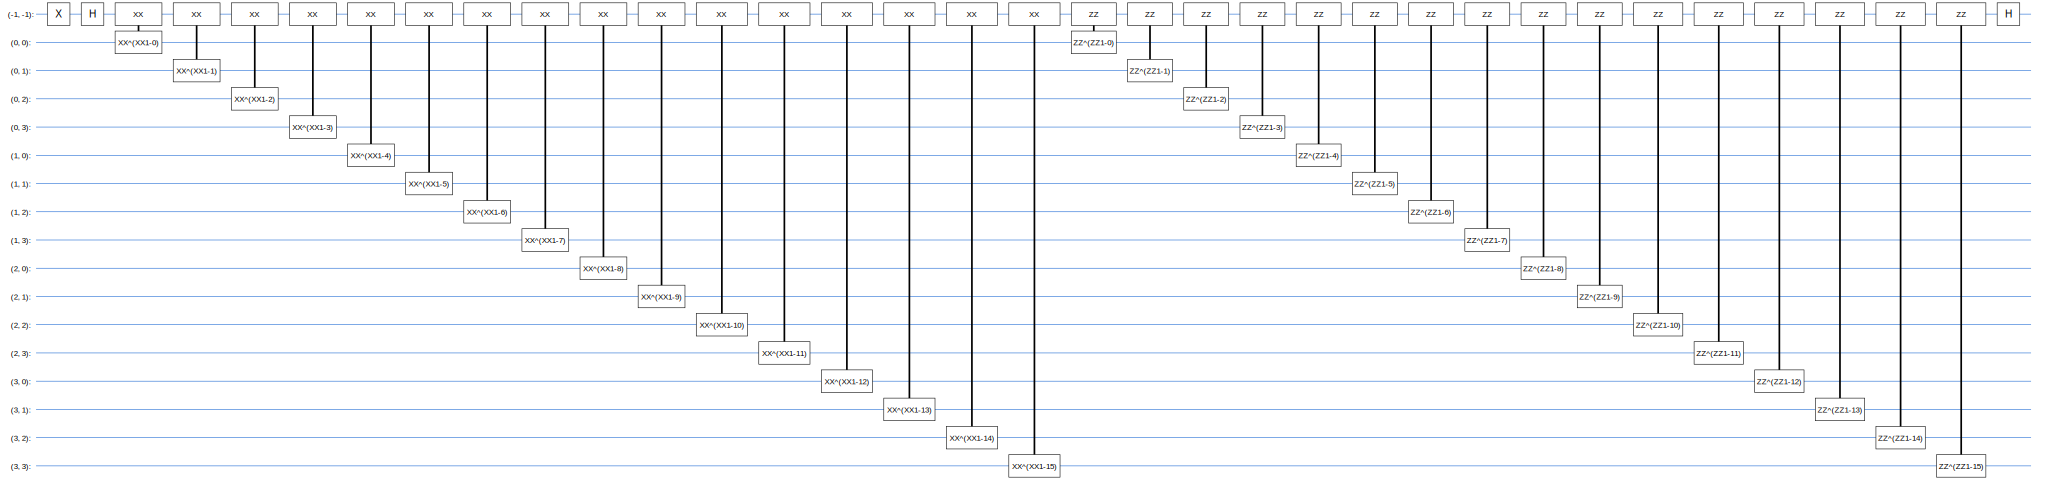

In [6]:
# Continue defining methods for building qNN model architecture

def create_quantum_model():
# Create circuit representation of a simple qNN model with corresponding readout operation (aka output neuron)
    data_qbits = cirq.GridQubit.rect(4, 4) # qubit grid comprising image data
    readout_qbit = cirq.GridQubit(-1, -1) # single output qubit positioned at (-1, -1) on circuit grid
    circuit = cirq.Circuit()
    
    # preprocess quantum state of readout qubit by applying gate operations 
    circuit.append(cirq.X(readout_qbit)) # pauli X gate operation on readout
    circuit.append(cirq.H(readout_qbit)) # Hadamard gate operation on readout
    
    # initialize circuit layer builder with corresponding data and output qubits for this qNN model
    build = CircLayerBuilder(data_qbits = data_qbits, readout_qbit = readout_qbit)
    
    # add layers to qNN model circuit (selecting XX, ZZ gates mentioned in Farhi et al)
    build.add_layer(circuit, cirq.XX, "XX1") # apply XX gate on data qubits & readout qubit
    build.add_layer(circuit, cirq.ZZ, "ZZ1") # apply ZZ gate on data qubits & readout qubit
    
    # post-process readout qubit by applying Hadamard gate (quantum superposition of states)
    circuit.append(cirq.H(readout_qbit))
    return circuit, cirq.Z(readout_qbit) # return circuit for qNN model and measurement for resultant qubit


# instantiate basic qNN model and corresponding readout qubit (aka "output neuron")
model_circ, model_result = create_quantum_model()

# wrap qNN model circuit in TensorFlow Quantum keras model
# input layer for tf.keras.Sequential will be given qubit representation of image data contained in model_circ
# and output layer will return resultant qubit given by model_result
model = tf.keras.Sequential([tf.keras.layers.Input(shape=(), dtype = tf.string), tfq.layers.PQC(model_circ, model_result)])
print("\n==================== DISPLAYING qNN MODEL CIRCUIT  ====================")
SVGCircuit(model_circ)

For this binary classification problem, Farhi et al suggests that the model reports its predictions as the expectation obtained from measuring the state of the readout qubit contained in a parametrized quantum circuit. In this case, our values range in the interval \[-1, 1\] (-1 being associated with the binary label "False", representing category "6", and 1 being associated with the binary label "True", representing category "3"). For this reason, the authors of this TensorFlow Quantum tutorial propose using the hinge loss function for this model as the most natural measure of performance. 

To appropriately incorporate a hinge loss function, we must first convert our labels `y_train_rmcon` and `y_test_rmcon` from boolean values to values ranging in \[-1, 1\], then redefine a new hinge accuracy function that knows how to interpret this new range of values.

In [7]:
# Data preprocessing and custom method definitions for using hinge loss for qNN

def hinge_accuracy(y_true, y_pred):
# Custom definiton of hinge accuracy used to report performance of qNN's predictions y_pred 
# on data set with true labels y_true
    # convert labels in y_true and y_pred to boolean values satisfying condition: y_true, y_pred > 0.0
    y_true = tf.squeeze(y_true) > 0.0 # tf.squeeze return same tensor with size 1 dimensions removed
    y_pred = tf.squeeze(y_pred) > 0.0 # tf.squeeze return same tensor with size 1 dimensions removed
    result = tf.cast(y_true == y_pred, tf.float32) # recast resulting accuracy as tensor containing numerical values
    return tf.reduce_mean(result) # return average of the values in result

# preprocess labels by converting values from boolean to range [-1, 1]
y_train_hinge = 2.0*y_train_rmcon - 1.0
y_test_hinge = 2.0*y_test - 1.0

The last step to complete before finally compiling our qNN model involves wrapping the quantum model circuit we defined above in a TensorFlow Quantum model. We define our model using the `tf.keras.Sequential` class, for which we define an input layer that accepts a qubit representation of the image data contained in `model_circ`, and an output layer that returns the resultant (readout) qubit given by `model_result`.

In [8]:
# qNN model compilation & summary

# compile final qNN model
model.compile(loss=tf.keras.losses.Hinge(), optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

# display model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# train qNN model

epochs = 10
batch = 32
num_examples = len(x_train_tfq) # subject to change based on training time

# use subsets of training set for qNN for variable wait times for training
x_train_qNNsub = x_train_tfq[:num_examples]
y_train_qNNsub = y_train_hinge[:num_examples]

print("\n==================== FITTING qNN ON 4x4 PIXEL MNIST DATA  ====================")
# obtain training history for qNN
qnn_hist = model.fit(x_train_qNNsub, y_train_qNNsub, batch_size=32, epochs=epochs,
      verbose=1, validation_data=(x_test_tfq, y_test_hinge))

# obtain test results for qNN
qnn_results = model.evaluate(x_test_tfq, y_test)


==================== FITTING qNN ON 4x4 PIXEL MNIST DATA  ====================
Epoch 1/10
324/324 [==============================] - 687s 2s/step - loss: 0.3442 - hinge_accuracy: 0.8957 - val_loss: 0.3357 - val_hinge_accuracy: 0.9078
Epoch 2/10
324/324 [==============================] - 667s 2s/step - loss: 0.3441 - hinge_accuracy: 0.8946 - val_loss: 0.3342 - val_hinge_accuracy: 0.9073
Epoch 3/10
324/324 [==============================] - 672s 2s/step - loss: 0.3438 - hinge_accuracy: 0.8917 - val_loss: 0.3361 - val_hinge_accuracy: 0.9078
Epoch 4/10
324/324 [==============================] - 672s 2s/step - loss: 0.3435 - hinge_accuracy: 0.8943 - val_loss: 0.3368 - val_hinge_accuracy: 0.9083
Epoch 5/10
324/324 [==============================] - 654s 2s/step - loss: 0.3434 - hinge_accuracy: 0.8914 - val_loss: 0.3324 - val_hinge_accuracy: 0.9073
Epoch 6/10
324/324 [==============================] - 660s 2s/step - loss: 0.3435 - hinge_accuracy: 0.8956 - val_loss: 0.3358 - val_hinge_accurac

In [13]:
print(qnn_results[1])
print(qnn_hist.history['loss'])
print(qnn_hist.history['val_loss'])
print(qnn_hist.history['hinge_accuracy'])
print(qnn_hist.history['val_hinge_accuracy'])

0.9087701439857483
[0.34419289231300354, 0.3440631330013275, 0.3438284993171692, 0.34346142411231995, 0.34341877698898315, 0.34348756074905396, 0.34297600388526917, 0.3425918221473694, 0.3423813283443451, 0.34249237179756165]
[0.33568185567855835, 0.33421334624290466, 0.33614206314086914, 0.3367970585823059, 0.3324228525161743, 0.33577266335487366, 0.33289259672164917, 0.33313053846359253, 0.33681902289390564, 0.34032705426216125]
[0.8957368731498718, 0.8945794701576233, 0.891685962677002, 0.8942901492118835, 0.8913965821266174, 0.8956404328346252, 0.894000768661499, 0.8964120149612427, 0.8909143805503845, 0.8937114477157593]
[0.9077621102333069, 0.9072580933570862, 0.9077621102333069, 0.9082661271095276, 0.9072580933570862, 0.9082661271095276, 0.9077621102333069, 0.9077621102333069, 0.9087701439857483, 0.9087701439857483]


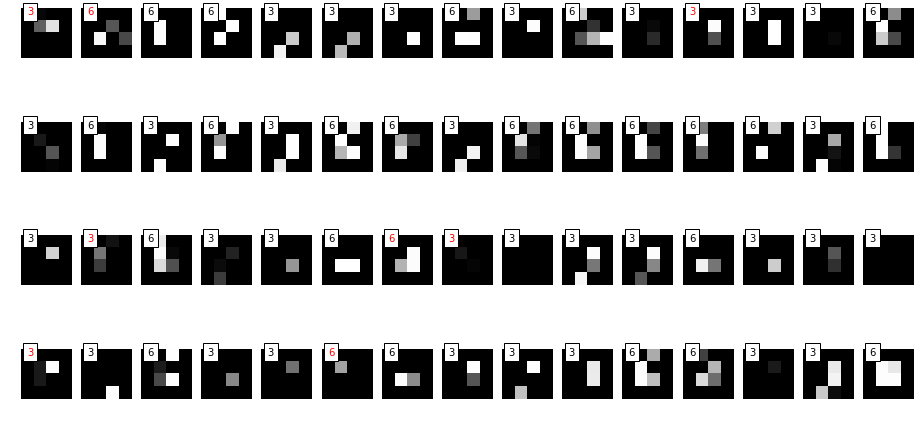

In [25]:
# show visual examples of sampled predictions
def show_results(model):
    rows = 4
    columns = 15
    sliced = rows*columns
    predicted = model.predict(x_test_tfq[:sliced])

    plt.figure(figsize=(16,8))
    for i in range(sliced):
        plt.subplot(rows, columns, i+1)
        plt.imshow(x_test_small[i, :, :, 0], cmap='gray', vmin=0.0, vmax=1.0)
        color = 'black' if y_test[i] == (math.ceil(predicted[i]) > 0) else 'red'
        res = 6
        if math.ceil(predicted[i]) > 0:
            res = 3
        plt.text(0, 0, res, color=color, 
                 bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

#show_results(model)
show_results(model)

## Comparing qNN Performance with that of a Classical Model

In [ ]:
# Define methods returning classical convolutional neural networks (cNNs)

def create_classical_cNN():
# Simple cNN for 3-6 binary classification problem based off of 
#keras example model: https://keras.io/examples/vision/mnist_convnet/

# Model comprises ~1.2M total weights;
# Input layer accepts image data represented as 28x28 pixel grid

    model = tf.keras.Sequential([tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                                                        activation='relu', 
                                                        input_shape=(28,28,1)),
                                tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
                                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                                tf.keras.layers.Dropout(0.25),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(128, activation='relu'), 
                                tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(1)])
    return model

def create_fair_cNN():
# Simple cNN for 3-6 binary classification problem based off of 
#keras example model: https://keras.io/examples/vision/mnist_convnet/

# Model comprises ~1.2M total weights;
# Input layer accepts image data represented as 4x4 pixel grid

    model = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(4,4,1)),
                           tf.keras.layers.Dense(2, activation='relu'), 
                          tf.keras.layers.Dense(1)])
    return model


# instantiate and train 2 cNNs on 3-6 binary classification problem: one standard/"optimized" cNN
# comprising 1.2M weights that accepts full 28x28 pixel image, and one with 
# comparable complexity to our qNN model (4x4 pixel input, 37 weights)

model_standard = create_classical_cNN()
model_fair = create_fair_cNN()

# compile models 
model_standard.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
model_fair.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# display model summaries 
print("\n==================== DISPLAYING MODEL SUMMARY: STANDARD cNN ====================")
model_standard.summary()
print("\n==================== DISPLAYING MODEL SUMMARY: FAIR cNN ====================")
model_fair.summary()

# fit models 
print("\n==================== FITTING STANDARD cNN ON 28x28 PIXEL MNIST DATA  ====================")
cnn_hist = model_standard.fit(x_train, y_train, batch_size=128, epochs=25, verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model_standard.evaluate(x_test, y_test)

print("\n==================== FITTING FAIR cNN ON 4x4 PIXEL MNIST DATA  ====================")
fair_cnn_hist = model_fair.fit(x_train_small, y_train, batch_size=128, epochs=25, verbose=1,
          validation_data=(x_test_small, y_test))

fair_cnn_results = model_fair.evaluate(x_test_small, y_test)


In [ ]:
# generate figures for performance comparison between models

sns.barplot(["qNN", "Standard cNN", "Fair cNN"],[qnn_results[1], cnn_results[1], fair_cnn_results[1]])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Prediction Loss per Epoch")
plt.plot(qnn_hist.history['loss'])
plt.plot(qnn_hist.history['val_loss'])
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.plot(fair_cnn_hist.history['loss'])
plt.plot(fair_cnn_hist.history['val_loss'])
plt.legend(['qNN Training', 'qNN Validation', 'Standard cNN Training', 'Standard cNN Validation', 'Fair cNN Validation', 'Fair cNN Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Prediction Accuracy per Epoch")
plt.plot(qnn_hist.history['hinge_accuracy'])
plt.plot(qnn_hist.history['val_hinge_accuracy'])
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(fair_cnn_hist.history['accuracy'])
plt.plot(fair_cnn_hist.history['val_accuracy'])
plt.legend(['qNN Training', 'qNN Validation', 'Standard cNN Training', 'Standard cNN Validation', 'Fair cNN Validation', 'Fair cNN Validation'])
